In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob


# Monthly online RMSE visualization

In this notebook, we evaluate the online monthly RMSE of temperature, moisture, zonal wind, and tota cloud. We provide the exactly code to reproduce the Figure 2 in "Stable Machine-Learning Parameterization of Subgrid Processes with Real Geography and Full-physics Emulation", Hu et al. 2024, arXiv preprint:2306.08754.

## Set data path

All the simulation output, saved model weights, and preprocessed data used in Hu et al. 2024 "Stable Machine-Learning Parameterization of Subgrid Processes with Real Geography and Full-physics Emulation" are provided in a hu_etal2024_data folder that you can download. Please change the following path to your downloaded hu_etal2024_data folder.

In [2]:
data_path = '/global/homes/z/zeyuanhu/scratch/hu_etal2024_data/'
data_path = '/media/peter/CrucialBX500/data/ClimSim/hu_etal2024_data/'

In [3]:
# open the one-year reference mmf simulation
ds_sp = xr.open_dataset(data_path + 'h0/1year/mmf_ref/mmf_ref.eam.h0.0003.nc')

In [4]:
ps_sp = ds_sp.PS
p_interface = ds_sp.hyai*ds_sp.P0 + ds_sp.hybi*ds_sp.PS
p_interface = p_interface.values
p_interface = np.transpose(p_interface, (1,0,2))
dp = p_interface[:,1:61,:] - p_interface[:,0:60,:]
area = ds_sp.area
area_weight = area.values[np.newaxis,np.newaxis,:]
total_weight = dp*area_weight
total_weight.shape

# Function to calculate RMSE per month for total cloud mixing ratio (liquid + ice)
def calculate_rmse_qn(ds1, ds2, total_weight):
    # Determine the number of months in ds1
    num_months = ds1['CLDLIQ'].shape[0]
    
    # Slice total_weight to match the number of months in ds1
    total_weight_sliced = total_weight[:num_months, :, :]
    
    # Initialize the RMSE array with NaN values
    rmse_per_month = np.full(12, np.nan)
    
    # Compute RMSE for existing months
    squared_diff = (ds1['CLDLIQ'] - ds2['CLDLIQ'] + ds1['CLDICE'] - ds2['CLDICE']) ** 2
    weighted_squared_diff = squared_diff * total_weight_sliced
    weighted_sum = weighted_squared_diff.sum(axis=(1, 2))
    total_weight_sum = total_weight_sliced.sum(axis=(1, 2))
    weighted_mean_squared_diff = weighted_sum / total_weight_sum
    rmse_existing_months = np.sqrt(weighted_mean_squared_diff)
    
    # Fill in the RMSE array with the computed values
    rmse_per_month[:num_months] = rmse_existing_months.values
    
    return rmse_per_month

# Function to calculate RMSE per month for other variables (T, Q, U)
def calculate_rmse(ds1, ds2, total_weight,var='T'):
    # Determine the number of months in ds1
    num_months = ds1[var].shape[0]
    
    # Slice total_weight to match the number of months in ds1
    total_weight_sliced = total_weight[:num_months, :, :]
    
    # Initialize the RMSE array with NaN values
    rmse_per_month = np.full(12, np.nan)
    
    # Compute RMSE for existing months
    squared_diff = (ds1[var] - ds2[var]) ** 2
    weighted_squared_diff = squared_diff * total_weight_sliced
    weighted_sum = weighted_squared_diff.sum(axis=(1, 2))
    total_weight_sum = total_weight_sliced.sum(axis=(1, 2))
    weighted_mean_squared_diff = weighted_sum / total_weight_sum
    rmse_existing_months = np.sqrt(weighted_mean_squared_diff)
    
    # Fill in the RMSE array with the computed values
    rmse_per_month[:num_months] = rmse_existing_months.values
    
    return rmse_per_month

In [7]:
# Load the three other mmf simulations that share the same initial condition of the reference mmf run but diverge due to random numerical round off error due to GPU calculation. 
ds_sp_re = xr.open_dataset(data_path + 'h0/1year/mmf_a/mmf_a.eam.h0.0003.nc')
ds_sp_re_b = xr.open_dataset(data_path + 'h0/1year/mmf_b/mmf_b.eam.h0.0003.nc')
ds_sp_re_c = xr.open_dataset(data_path + 'h0/1year/mmf_c/mmf_c.eam.h0.0003.nc')

# NN case groups
case_groups = [
    [
        'unet_v4/huber_rop',
        'unet_v4/huber_step',
        'unet_v4/mae_step'
    ],
    #[
    #    'mlp_v2/huber_rop',
    #    'mlp_v2/huber_step',
    #    'mlp_v2/mae_step'
    #],
    [
        'unet_v5/huber_rop',
        'unet_v5/huber_step',
        'unet_v5/mae_step'
    ],
    [
        'RNN/huber',
        'RNN/hybrid'
    ],
        [
        'RNN/huber_mem'
    ],
]


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray as xr

# Load precomputed offline R-square for the three baseline models: MLP, U-Net v4 and U-Net v5 (constrained by cloud physics).
r2_v5_unet = np.load('/global/u2/z/zeyuanhu/notebooks/james-plots/r2_final/r2-v5_unet_nonaggressive_cliprh_huber_rop2_r2.npy')
r2_v4_unet = np.load('/global/u2/z/zeyuanhu/notebooks/james-plots/r2_final/r2-v4plus_unet_nonaggressive_cliprh_huber_rop2_r3.npy')
r2_mlp = np.load('/global/u2/z/zeyuanhu/notebooks/james-plots/r2_final/r2-v2rh_mlp_nonaggressive_cliprh_huber_rop_3l_lr1em3_r2.npy')

# Generate x-axis values (feature indices)
features = np.arange(r2_v5_unet.size)

# Create a figure and axes
fig, axs = plt.subplots(3, 2, figsize=(17, 15), gridspec_kw={'height_ratios': [1, 1, 1], 'width_ratios': [2, 1]})
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Adjust the upper wide panel position
axs[0, 0].set_position([0.05, 0.75, 0.9, 0.22])
axs[0, 1].set_visible(False)  # Hide the upper right blank plot

# Adjust the second row panels positions
axs[1, 0].set_position([0.05, 0.45, 0.4, 0.22])
axs[1, 1].set_position([0.55, 0.45, 0.4, 0.22])

# Adjust the third row panels positions
axs[2, 0].set_position([0.05, 0.15, 0.4, 0.22])
axs[2, 1].set_position([0.55, 0.15, 0.4, 0.22])


# First upper wide panel
ax = axs[0, 0]
ax.plot(features, r2_v4_unet, linestyle='-', marker='o', color='cyan', label='Unet', linewidth=2, markersize=6)
ax.plot(features, r2_v5_unet, linestyle='-', marker='o', color='red', label='Unet+physics constraints', linewidth=2, markersize=6)
ax.plot(features, r2_mlp, linestyle='-', marker='o', color='blue', label='MLP', linewidth=2, markersize=6)
ax.set_xticks([30, 90, 150, 210, 270, 330, 365])
ax.set_xticklabels([r'$dT/dt$', r'$dQ_{\mathrm{vapor}}/dt$', r'$dQ_{\mathrm{liq}}/dt$', r'$dQ_{\mathrm{ice}}/dt$', r'$dU/dt$', r'$dV/dt$', 'Fluxes'], fontsize=24)
ax.axvline(x=60, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=120, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=180, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=240, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=300, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=360, color='gray', linestyle='--', linewidth=0.5)
ax.set_ylim(0, 1)
ax.set_xlim(0, 368)

shading_intervals = [(0, 30), (60, 90), (120, 150), (180, 210), (240, 270), (300, 330)]
for start, end in shading_intervals:
    ax.axvspan(start, end, color='gray', alpha=0.15)

ax.set_title('(a) Offline R²', fontsize=20, pad=35)
# Add horizontal arrows with ax.annotate outside ylim range and labels 'Top' and 'Bottom'
arrow_positions = [(0, 60), (60, 120), (120, 180), (180, 240), (240, 300), (300, 360)]
for start, end in arrow_positions:
    ax.annotate('', xy=(end, 1.025), xytext=(start, 1.025),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
                ha='center', va='bottom', annotation_clip=False)
    ax.text(start+1, 1.06, 'Top', ha='left', va='center', fontsize=15)
    ax.text(end-1, 1.06, 'Bottom', ha='right', va='center', fontsize=15)
    
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

FileNotFoundError: [Errno 2] No such file or directory: '/global/u2/z/zeyuanhu/notebooks/james-plots/r2_final/r2-v5_unet_nonaggressive_cliprh_huber_rop2_r2.npy'

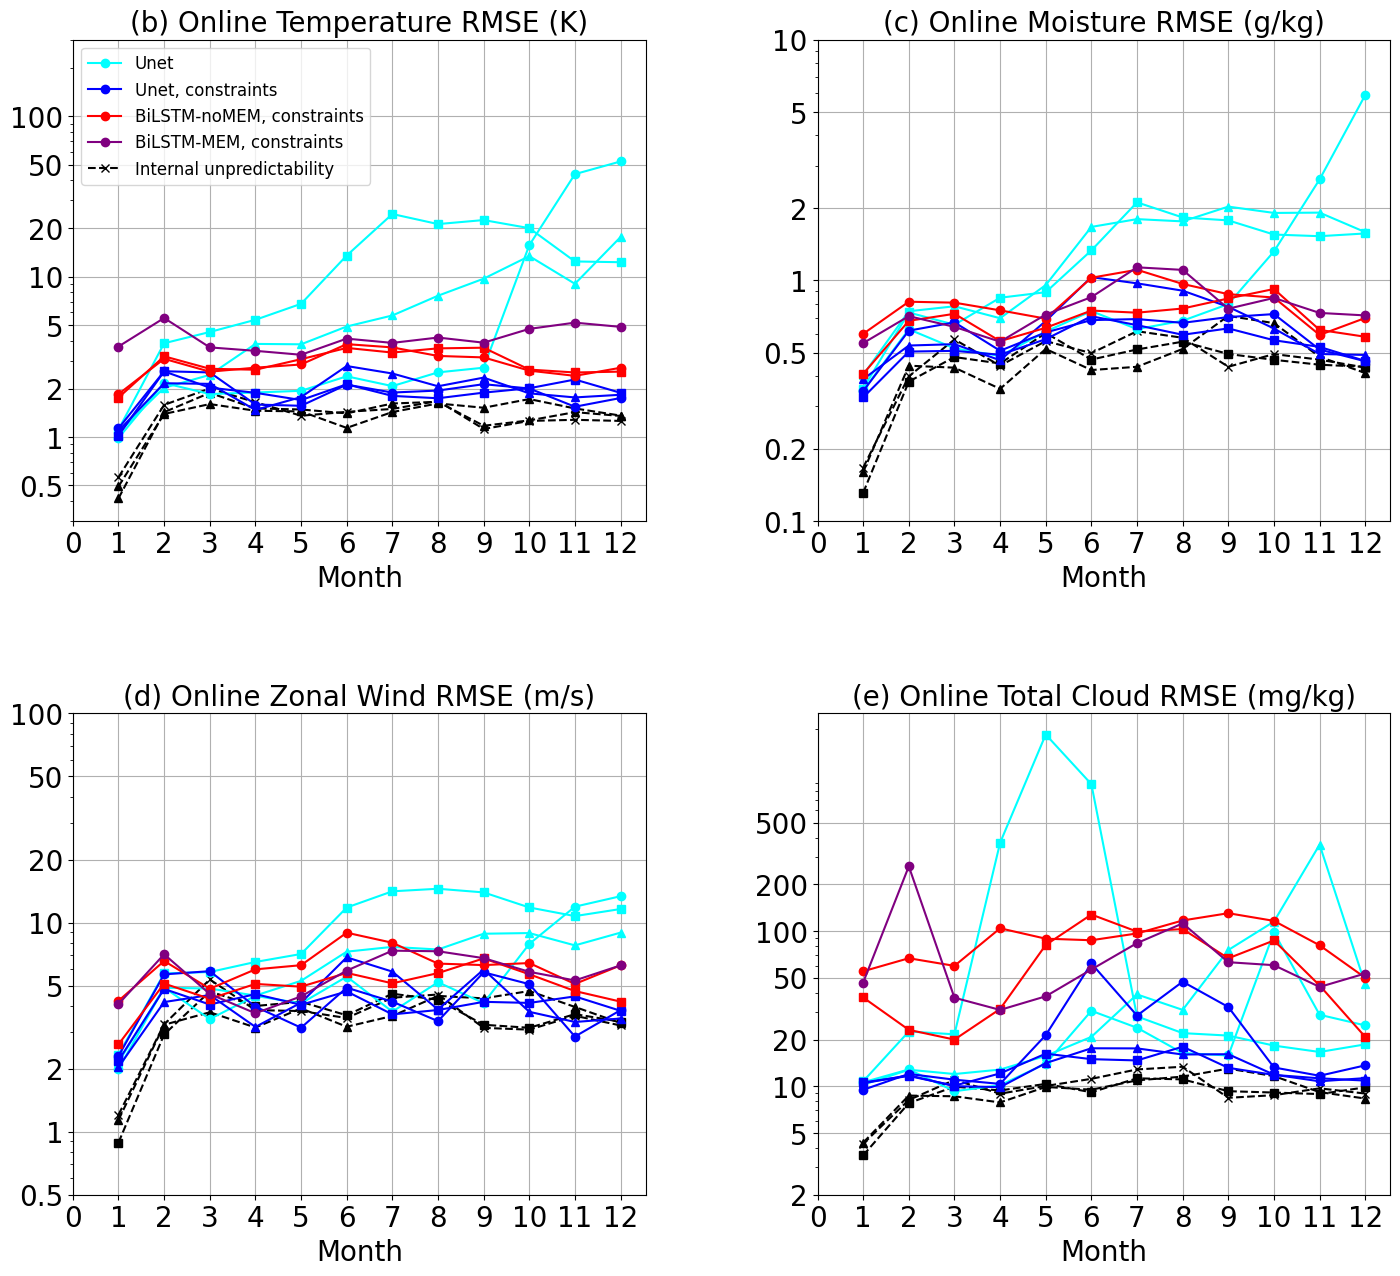

In [9]:
labels =  ['Unet, expanded inp.', 'Unet, expanded inp. + constraints', 'BiLSTM-noMEM, expanded inp. + constraints']
desired_order = [ 'Unet, expanded inp.', 
                 'Unet, expanded inp. + constraints', 'BiLSTM-noMEM, expanded inp. + constraints','Internal unpredictability']

labels =  ['Unet', 'Unet, constraints', 'BiLSTM-noMEM, constraints', 'BiLSTM-MEM, constraints']
desired_order = [ 'Unet', 'Unet, constraints', 'BiLSTM-noMEM, constraints', 'BiLSTM-MEM, constraints', 'Internal unpredictability']


# Second row left panel (lower left)
#fig, axs = plt.subplots(3, 2, figsize=(17, 15), gridspec_kw={'height_ratios': [1, 1, 1], 'width_ratios': [2, 1]})
fig, axs = plt.subplots(2, 2, figsize=(17, 15), gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1]})

fig.subplots_adjust(hspace=0.4, wspace=0.3)

ax = axs[0, 0]
colors = ['cyan', 'blue', 'red', 'purple']
markers = ['o', 's', '^', 'D']
var = 'T'
lines_labels = {}

rmse_per_month_sp_re = calculate_rmse(ds_sp_re, ds_sp, total_weight, var)
line, = ax.plot(np.arange(1, 13), rmse_per_month_sp_re, label='Internal unpredictability', color='black', linestyle='--', marker='x')
lines_labels['Internal unpredictability'] = line

rmse_per_month_sp_re_b = calculate_rmse(ds_sp_re_b, ds_sp, total_weight, var)
ax.plot(np.arange(1, 13), rmse_per_month_sp_re_b, label='', color='black', linestyle='--', marker='^')
rmse_per_month_sp_re_c = calculate_rmse(ds_sp_re_c, ds_sp, total_weight, var)
ax.plot(np.arange(1, 13), rmse_per_month_sp_re_c, label='', color='black', linestyle='--', marker='^')

for group_idx, group in enumerate(case_groups):
    for case_idx, casename in enumerate(group):
        ds_nn = xr.open_mfdataset(data_path + f'h0/1year/{casename}/*.eam.h0.0003-*.nc')
        rmse_per_month_nn = calculate_rmse(ds_nn, ds_sp, total_weight, var)
        months = np.arange(1, 13)
        label = None
        if case_idx == 0:
            label = labels[group_idx]
        line, = ax.plot(months, rmse_per_month_nn, label=label, color=colors[group_idx], marker=markers[case_idx])
        if label:
            lines_labels[label] = line

ax.set_yscale('log')
ax.set_yticks([0.5, 1, 2, 5, 10, 20, 50, 100])
ax.set_yticklabels(['0.5', '1', '2', '5', '10', '20', '50', '100'], fontsize=20)
ax.set_xlabel('Month', fontsize=20)
ax.set_ylabel('', fontsize=20)
ax.set_title('(b) Online Temperature RMSE (K)', fontsize=20)
#desired_order = ['MLP', 'Unet + expanded inputs', 'Unet + expanded inputs + microphysical constraints', 'Internal unpredictability']
ax.legend([lines_labels[label] for label in desired_order], desired_order, fontsize=12, loc='upper left')
ax.grid(True)
ax.set_xticks([0] + list(np.arange(1, 13)))
ax.set_xticklabels([0] + list(np.arange(1, 13)), fontsize=20)
ax.set_ylim(0.3, 300)

# Second row right panel (lower right)
ax = axs[0, 1]
var = 'Q'
rmse_per_month_sp_re = calculate_rmse(ds_sp_re, ds_sp, total_weight, var) * 1e3
ax.plot(np.arange(1, 13), rmse_per_month_sp_re, label='Internal unpredictability', color='black', linestyle='--', marker='x')
rmse_per_month_sp_re_b = calculate_rmse(ds_sp_re_b, ds_sp, total_weight, var) * 1e3
ax.plot(np.arange(1, 13), rmse_per_month_sp_re_b, label='', color='black', linestyle='--', marker='^')
rmse_per_month_sp_re_c = calculate_rmse(ds_sp_re_c, ds_sp, total_weight, var) * 1e3
ax.plot(np.arange(1, 13), rmse_per_month_sp_re_c, label='', color='black', linestyle='--', marker='s')

for group_idx, group in enumerate(case_groups):
    for case_idx, casename in enumerate(group):
        ds_nn = xr.open_mfdataset(data_path + f'h0/1year/{casename}/*.eam.h0.0003-*.nc')
        rmse_per_month_nn = calculate_rmse(ds_nn, ds_sp, total_weight, var) * 1e3
        label = None
        if case_idx == 0:
            label = labels[group_idx]
        ax.plot(np.arange(1, 13), rmse_per_month_nn, label=label, color=colors[group_idx], marker=markers[case_idx])

ax.set_yscale('log')
ax.set_yticks([0.1, 0.2, 0.5, 1, 2, 5, 10])
ax.set_yticklabels(['0.1', '0.2', '0.5', '1', '2', '5', '10'], fontsize=20)
ax.set_xlabel('Month', fontsize=20)
ax.set_ylabel('', fontsize=20)
ax.set_title('(c) Online Moisture RMSE (g/kg)', fontsize=20)
ax.grid(True)
ax.set_xticks([0] + list(np.arange(1, 13)))
ax.set_xticklabels([0] + list(np.arange(1, 13)), fontsize=20)

# Third row left panel (lower left)
ax = axs[1, 0]
var = 'U'
rmse_per_month_sp_re = calculate_rmse(ds_sp_re, ds_sp, total_weight, var)
ax.plot(np.arange(1, 13), rmse_per_month_sp_re, label='Internal unpredictability', color='black', linestyle='--', marker='x')
rmse_per_month_sp_re_b = calculate_rmse(ds_sp_re_b, ds_sp, total_weight, var)
ax.plot(np.arange(1, 13), rmse_per_month_sp_re_b, label='', color='black', linestyle='--', marker='^')
rmse_per_month_sp_re_c = calculate_rmse(ds_sp_re_c, ds_sp, total_weight, var)
ax.plot(np.arange(1, 13), rmse_per_month_sp_re_c, label='', color='black', linestyle='--', marker='s')

for group_idx, group in enumerate(case_groups):
    for case_idx, casename in enumerate(group):
        ds_nn = xr.open_mfdataset(data_path + f'h0/1year/{casename}/*.eam.h0.0003-*.nc')
        rmse_per_month_nn = calculate_rmse(ds_nn, ds_sp, total_weight, var)
        months = np.arange(1, 13)
        label = None
        if case_idx == 0:
            label = labels[group_idx]
        ax.plot(months, rmse_per_month_nn, label=label, color=colors[group_idx], marker=markers[case_idx])

ax.set_yscale('log')
ax.set_yticks([0.5, 1, 2, 5, 10, 20, 50, 100])
ax.set_yticklabels(['0.5', '1', '2', '5', '10', '20', '50', '100'], fontsize=20)
ax.set_xlabel('Month', fontsize=20)
ax.set_ylabel('', fontsize=20)
ax.set_title('(d) Online Zonal Wind RMSE (m/s)', fontsize=20)
ax.grid(True)
ax.set_xticks([0] + list(np.arange(1, 13)))
ax.set_xticklabels([0] + list(np.arange(1, 13)), fontsize=20)

# Third row right panel (lower right) total cloud
ax = axs[1, 1]
rmse_per_month_sp_re = calculate_rmse_qn(ds_sp_re, ds_sp, total_weight) * 1e6
ax.plot(np.arange(1, 13), rmse_per_month_sp_re, label='Internal unpredictability', color='black', linestyle='--', marker='x')
rmse_per_month_sp_re_b = calculate_rmse_qn(ds_sp_re_b, ds_sp, total_weight) * 1e6
ax.plot(np.arange(1, 13), rmse_per_month_sp_re_b, label='', color='black', linestyle='--', marker='^')
rmse_per_month_sp_re_c = calculate_rmse_qn(ds_sp_re_c, ds_sp, total_weight) * 1e6
ax.plot(np.arange(1, 13), rmse_per_month_sp_re_c, label='', color='black', linestyle='--', marker='s')

for group_idx, group in enumerate(case_groups):
    for case_idx, casename in enumerate(group):
        ds_nn = xr.open_mfdataset(data_path + f'h0/1year/{casename}/*.eam.h0.0003-*.nc')
        rmse_per_month_nn = calculate_rmse_qn(ds_nn, ds_sp, total_weight) * 1e6
        label = None
        if case_idx == 0:
            label = labels[group_idx]
        ax.plot(np.arange(1, 13), rmse_per_month_nn, label=label, color=colors[group_idx], marker=markers[case_idx])

ax.set_yscale('log')
ax.set_yticks([2, 5, 10, 20, 50, 100, 200, 500])
ax.set_yticklabels(['2', '5', '10', '20', '50', '100', '200', '500'], fontsize=20)
ax.set_xlabel('Month', fontsize=20)
ax.set_ylabel('', fontsize=20)
ax.set_title('(e) Online Total Cloud RMSE (mg/kg)', fontsize=20)
ax.grid(True)
ax.set_xticks([0] + list(np.arange(1, 13)))
ax.set_xticklabels([0] + list(np.arange(1, 13)), fontsize=20)
# plt.savefig('james_ablation_offline_online_reorder_warrow.pdf', format='pdf', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()